# ADA PROJECT - Amazon Kindle User Experience
### MILESTONE 3
### E. Bonvin, D. Dudzicz, X. Pantet

## Project Presentation and Research Question Summary

In the scope of our project, we decided to analyze the impact that Amazon's Kindle on its customers' reading habits. We are interested in seeing whether the e-reader from the e-commerce giant has an effect on users' behaviour and if it does, how these are being modified. Our main analysis axis were the variations and shifts in tendencies that can be observed from the launch of the Kindle in November 2007 until 2014.

We articulate our analysis around the following research questions:

- Is the Kindle getting more readers than classical books with respect to the size of the available titles catalogs?
- Has the Kindle changed frequent readers' reading habits or reading pace?
- Is the Kindle successfuly retaining the new users who try it?
- How important is the Kindle in the proportion of books read for frequent users?
- How is users' ebooks-books proportion varying in time?
- Is the technical aspect of the medium an important satisfaction factors in customers' reviews?

## Results Computation Disclaimer

Due to Jupyter Notebooks tendency to halt for no reason, its repeated crashes with heavy computations and Pyspark's habit not to implement a lot of common MySQL operators, a lot of presented results had to be computed using Python 3 and Scala Spark without Jupyter Notebook. Those results are imported and appear to be magic values but they are not. We also spare the reader with boring extensive SQL querying given its simplicity and tediousness.

In [617]:
#Imports of mathematical and statistical libraries
import pandas as pd
import numpy as np
import statistics

#Imports of pyspark functions
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.sql.functions import col
import os.path
import findspark

#Imports of graphical representations and plotting libraries
import matplotlib.pyplot as plt
import seaborn as snb
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from IPython.display import Image

#Imports for LDA
from collections import Counter
from pyspark.ml.clustering import LDA, LDAModel, DistributedLDAModel
from pyspark.ml.linalg import Vectors

#Imports of natural language processing libraries
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer

#PySpark SQL context creation
findspark.init()
sc = pyspark.SparkContext()
sc.setCheckpointDir('checkpoint/')
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

## Analysis Structure

Our analysis is divided into two main parts. The first one tackles the purely quantitative and numerical aspects of the reviews. We analyze the number and proportion of users for each platform, their monthly consumption, etc.

The second one presents a sentiment analysis on the review texts of the Kindle in order to enhance the precision of the tendency observed in part one.

## Datasets Used

We use four datasets consisting of amazon reviews gathered by Julian McAuley (UCSD) available on http://jmcauley.ucsd.edu/data/amazon/. These datasets contain various amazon customers reviews collected from May 1996 to July 2014.

The data is very-well formated thanks to the work of the author and is categorized given the kind of item being reviewed. We used the following datasets:

- ratings_Books.csv (~900MB)
- ratings_Kindle_Store.csv (~130MB)
- reviews_Books.json (~20GB)
- reviews_Kindle_Store.json (~2.2GB)

The two first datasets are simplified versions of their respective latter files. They are much lighter, only presenting numerical values of the reviews. They consist of 4-tuples:

- __userID:__ a unique ID of each customer that is coherent among all dataset present on the website
- __ASIN:__ the unique amazon product id number
- __rating:__ the rating of the review in the range [1,5] stars
- __unixTimestamp:__ the timestamp in the UNIX epoch format

The last two datasets are much more complete:

- __userID__
- __ASIN__
- __userName:__ the customer real name
- __helpful:__ the helpfulness of the review as a ratio given by other amazon customers
- __reviewText:__ the review text itself
- __rating__
- __summary:__ the summary of the review
- __unixTimestamp__
- __reviewTime:__ timestamp in a human readable format

Even though, these datasets hold a lot of informations, we focused only on the reviewText field. Indeed, all the key aspects that we needed for the first part of the analysis are present in the two first reduced datasets.

## Data Cleaning

Since the datasets are very well formated thanks to the work of Julian McAuley (UCSD), we do not have any data cleaning to do properly speaking. On the other hand, there are some inconsistencies in the ratings and reviews that we have to deal with (too many reviews per user per period of time, incoherent `reviewTime` given the release date of the Kindle) that need to be filtered. Those are explained in the latter parts when needed.

## Data Loading

We define the global environment variables that allow us to read data and store intermediate results during our work. We also defines schema for .csv file imports but not for .json which do not require it.

In [2]:
#Global variable definitions
DATA_FOLDER = 'data/'
RESULT_FOLDER = 'results/'
RDD_FILENAME = "stemstem.parquet"

#Name of the datasets files downloaded from http://jmcauley.ucsd.edu/data/amazon/
RATINGS_KINDLE = 'ratings_Kindle_Store.csv'
RATINGS_BOOKS = 'ratings_Books.csv'

#Schema for books and kindle ratings
RATINGS_SCHEMA = StructType([
    StructField("User", StringType(), True),
    StructField("Asin", StringType(), True),
    StructField("Ratings", FloatType(), True),
    StructField("Timestamp", IntegerType(), True)])

#Schema for reading saved kindle catalogue size
KINDLE_CATALOGUE_SCHEMA = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Kindle_catalogue_size", IntegerType(), True)])

#Schema for reading saved books catalogue size
BOOKS_CATALOGUE_SCHEMA = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Books_catalogue_size", IntegerType(), True)])

RATINGS_USER = 0
RATINGS_ASIN = 1
RATINGS_RATINGS = 2
RATINGS_TIMESTAMP = 3

In [146]:
# Ratings datasets

# Kindle
df_ratings_kindle = spark.read.csv(DATA_FOLDER + RATINGS_KINDLE, header = False, schema = RATINGS_SCHEMA)
print("---Kindle rating data sample---")
print(df_ratings_kindle.head(5))

# Books
df_ratings_books = spark.read.csv(DATA_FOLDER + RATINGS_BOOKS, header = False, schema = RATINGS_SCHEMA)
print("---Books rating data sample---")
print(df_ratings_books.head(5))

#We register the datasets to be used in the SQL queries in the latter parts
df_ratings_kindle.registerTempTable("ratings_kindle")
df_ratings_books.registerTempTable("ratings_books")

In [ ]:
#Reviews datasets
df_kindle_reviews = spark.read.json("data/reviews_Kindle_Store.json")
df_books_reviews = spark.read.json("data/reviews_Books.json")

## Part 1 - Quantitative results

### 1.1 Kindle popularity growth

In this subpart, we desire to observe if the Kindle appeals more to new users than books. We desire to observe the tendency with respect to the size of the ebooks and books catalogs.

In [156]:
#We previously computed the size of the catalogue of the kindle and books on amazon per year and we stored it in parquet files
#we do not include the detail of the computations as it is very simple and tidious SQL queries which will be still very present
#in the rest of the notebook.
df_kindle_catalogue_years = spark.read.csv(RESULT_FOLDER+'kindle_catalogue_size_year.csv', header = False, schema = KINDLE_CATALOGUE_SCHEMA)
df_kindle_catalogue_years.registerTempTable("df_kindle_catalogue_years")
df_books_catalogue_years = spark.read.csv(RESULT_FOLDER+'books_catalogue_years.csv', header = False, schema = BOOKS_CATALOGUE_SCHEMA)
df_books_catalogue_years.registerTempTable("df_books_catalogue_years")

In [157]:
#We compute the numbers of the new kindle users starting from 2008 since the kindle launched in 2007. Odly we have
#observed that there were a lot of kindle reviews even before 2006. We need to filter this erroneous data first.
kindle_new_users_by_years = spark.sql("""
                                SELECT year, COUNT(User) AS new_users
                                FROM 
                                (SELECT User, YEAR(FROM_UNIXTIME(MIN(Timestamp))) AS year
                                FROM ratings_kindle
                                WHERE YEAR(FROM_UNIXTIME(Timestamp)) > 2007
                                GROUP BY User)
                                GROUP BY Year
                                ORDER BY year
                            """)
kindle_new_users_by_years.registerTempTable("kindle_users_by_years")

In [158]:
#We observed that the books variation was very important before the kindle appearance and we settled on a prior five year
#before the kindle launched year basis for our books baseline.
books_new_users_by_years = spark.sql("""
                                SELECT year, COUNT(User) AS new_users
                                FROM 
                                (SELECT User, YEAR(FROM_UNIXTIME(MIN(Timestamp))) AS year
                                FROM ratings_books
                                WHERE YEAR(FROM_UNIXTIME(Timestamp)) > 2003 
                                GROUP BY User)
                                GROUP BY Year
                                ORDER BY year
                            """)
books_new_users_by_years.registerTempTable("books_users_by_years")

In [160]:
#Covnersion to pandas
df_books_catalogue_years = df_books_catalogue_years.orderBy('Year').toPandas()
df_kindle_catalogue_years = df_kindle_catalogue_years.orderBy('Year').toPandas()
df_kindle_new_users_by_years = kindle_new_users_by_years.toPandas()
df_books_new_users_by_years = books_new_users_by_years.toPandas()

#Normalization and removal of 2014 outliers since the gathering wasn't complete for this last year.
books_users_normalized = df_books_new_users_by_years['new_users']/df_books_catalogue_years['Books_catalogue_size']
books_users_normalized = books_users_normalized[:-2]
kindle_users_normalized = df_kindle_new_users_by_years['new_users']/df_kindle_catalogue_years['Kindle_catalogue_size']
kindle_users_normalized = kindle_users_normalized[:-2]

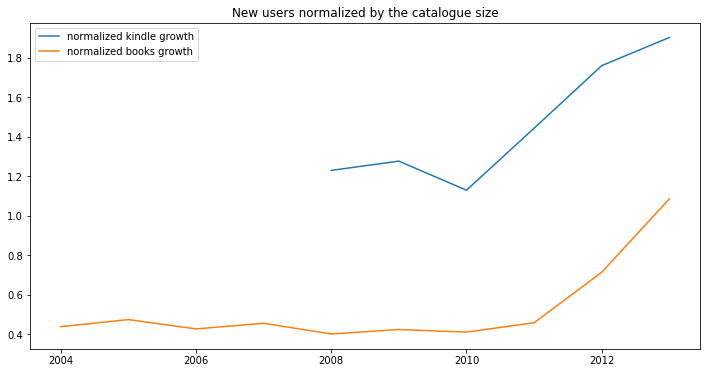

In [161]:
years1 = (df_kindle_new_users_by_years['year'])[:-1]
years2 = (df_books_new_users_by_years['year'])[:-1]

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
plt.title("New users normalized by the catalogue size")
ax.plot(years1,kindle_users_normalized, label='normalized kindle growth')
ax.plot(years2,books_users_normalized, label='normalized books growth')
plt.legend()
plt.show()

It appears that __new users are more interested by the Kindle than by the books__ with respect to the size of the catalog. However both mediums have an important and __similar increase in growth starting in 2011__, in a similar manner as the Amazon.com brand popularity growth ref. [https://www.statista.com/chart/4298/amazons-long-term-growth/.] The fact that book curve is lower has to be nuanced, since the Amazon books offer was already present in 1996, almost 10 years before the first datapoint, we are plotting here. This has to be taken into account. Nonetheless, we can observe that the __Kindle has an important popularity among newcomers__.

### 1.2 Change in frequent users' reading habits

We observed in 1.1 that the the Kindle was able to appeal to newcomers, but has it been successfull in noticeably changing frequent users reading behaviour? We want to observe the effect of the Kindle on frequent users' reading habits and monthly pace of reading.

In [443]:
#We need to get first users who consume both mediums in order to have a meaningful point of comparison. It would be
#of little interest to compare separate popultions.
common_users = spark.sql("""SELECT DISTINCT ratings_books.User
                            FROM ratings_books
                            WHERE ratings_books.User
                            IN (SELECT ratings_kindle.User
                            FROM ratings_kindle
                            WHERE YEAR(FROM_UNIXTIME(ratings_kindle.Timestamp)) > 2007)""")

common_users.write.parquet(RESULT_FOLDER+"common_users_list")
common_users = spark.read.parquet(RESULT_FOLDER+"common_users_list")
common_users.registerTempTable("common_users")

We desire to obtain users who already owned books before the Kindle appearance.
In this step we also filter out readers who consume __more than 30 books a month__. We decided to discard these outliers since we have discovered that amazon.com was victim of faked and spoofed ratings that aimed to artificially increase the grade of certain products ref. [https://www.independent.co.uk/news/business/news/amazon-bans-biased-reviews-incentivised-a7344761.html].

In [447]:
#Users who owns a kindle an who were reading books before its appearance
old_books_users = spark.sql("""SELECT User, 
                                      YEAR(FROM_UNIXTIME(ratings_books.Timestamp)) AS year,
                                      MONTH(FROM_UNIXTIME(ratings_books.Timestamp)) AS month,
                                      COUNT(ASIN) as nb_books
                                      FROM ratings_books
                                      WHERE YEAR(FROM_UNIXTIME(ratings_books.Timestamp)) <= 2007 AND
                                      YEAR(FROM_UNIXTIME(ratings_books.Timestamp)) >= 2004 AND
                                      ratings_books.User IN
                                          (SELECT * FROM common_users)
                                      GROUP BY User, year, month
                                      HAVING nb_books < 30""")

In [167]:
#Writing results to parquet and reading them to accelerate latter queries.
old_books_users.write.parquet(RESULT_FOLDER+"old_books_monthly_read")
old_books_monthly_read = spark.read.parquet(RESULT_FOLDER+"old_books_monthly_read")
old_books_monthly_read.registerTempTable("old_books_monthly_read")

We desire to retain only frequent readers to have a better point of view of their habits. We define a threshold of __at least 6 books a year__.

In [168]:
old_books_users_avg_montly = spark.sql("""SELECT year, month, AVG(nb_books) AS monthly_books
                                          FROM old_books_monthly_read
                                          JOIN (SELECT User 
                                                FROM old_books_monthly_read
                                                GROUP BY User, Year
                                                HAVING SUM(nb_books) > 5) t
                                          ON  old_books_monthly_read.User = t.User     
                                          GROUP BY year, month
                                          ORDER BY year, month""")

In [ ]:
#Writing results to parquet and reading them to accelerate latter queries.
old_books_users_avg_montly.write.parquet(RESULT_FOLDER+ 'old_books_users_avg_montly')
old_books_users_avg_montly = spark.read.parquet(RESULT_FOLDER+ 'old_books_users_avg_montly')
old_books_users_avg_montly.registerTempTable("old_books_users_avg_montly")

In [9]:
#common users kindle ebooks purchases
df_common_kindle = spark.sql("""SELECT *
                              FROM ratings_kindle
                              WHERE YEAR(FROM_UNIXTIME(ratings_kindle.Timestamp)) > 2007 AND
                              ratings_kindle.User IN
                              (SELECT * FROM common_users)""")
df_common_kindle.registerTempTable("common_kindle")
df_common_kindle.write.parquet(RESULT_FOLDER+"kindle_reviews")
df_users_reduced = df_kindle_proportion_time.select('User')
df_users_reduced.registerTempTable("df_users_reduced")

In [15]:
#common users books purchases
df_common_books = spark.sql("""SELECT *
                              FROM ratings_books
                              WHERE YEAR(FROM_UNIXTIME(ratings_books.Timestamp)) > 2007 
                              AND ratings_books.User IN
                              (SELECT * FROM common_users)""")
df_common_books.registerTempTable("common_books")
df_common_books.write.parquet(RESULT_FOLDER+"books_review")

In [194]:
common_books_user_time = spark.sql("""SELECT User, YEAR(FROM_UNIXTIME(Timestamp)) AS Year, MONTH(FROM_UNIXTIME(Timestamp)) AS Month, COUNT(Asin) AS nb_books, AVG(Ratings) AS avg_book_rating
                                  FROM common_books
                                  GROUP BY User, YEAR(FROM_UNIXTIME(Timestamp)), MONTH(FROM_UNIXTIME(Timestamp))""")
common_books_user.registerTempTable("common_books_user_time")

In [195]:
common_kindle_user_time = spark.sql("""SELECT User, YEAR(FROM_UNIXTIME(Timestamp)) AS Year, MONTH(FROM_UNIXTIME(Timestamp)) AS Month, COUNT(Asin) AS nb_ebooks, AVG(Ratings) AS avg_kindle_rating
                                  FROM common_kindle
                                  GROUP BY User, YEAR(FROM_UNIXTIME(Timestamp)), MONTH(FROM_UNIXTIME(Timestamp))""")
common_kindle_user.registerTempTable("common_kindle_user_time")

In [196]:
#Merge of the tables
time_usage = spark.sql("""SELECT 
                            common_kindle_user_time.User AS User,
                            common_kindle_user_time.Year AS Year,
                            common_kindle_user_time.Month as Month,
                            common_kindle_user_time.nb_ebooks AS nb_ebooks,
                            common_books_user_time.nb_books AS nb_books,
                            common_kindle_user_time.avg_kindle_rating AS avg_kindle_rating,
                            common_books_user_time.avg_book_rating AS avg_book_rating
                            FROM common_kindle_user_time
                            LEFT JOIN common_books_user_time
                            ON (common_kindle_user_time.User = common_books_user_time.User 
                            AND common_kindle_user_time.Year = common_books_user_time.Year 
                            AND common_kindle_user_time.Month = common_books_user_time.Month )
                            UNION
                            SELECT common_books_user_time.User AS User,
                            common_books_user_time.Year AS Year,
                            common_books_user_time.Month AS Month,
                            common_kindle_user_time.nb_ebooks AS nb_ebooks,
                            common_books_user_time.nb_books AS nb_books,
                            common_kindle_user_time.avg_kindle_rating AS avg_kindle_rating,
                            common_books_user_time.avg_book_rating AS avg_book_rating
                            FROM common_books_user_time
                            LEFT JOIN common_kindle_user_time 
                            ON (common_kindle_user_time.User = common_books_user_time.User 
                            AND common_kindle_user_time.Year = common_books_user_time.Year 
                            AND common_kindle_user_time.Month = common_books_user_time.Month )""")

time_usage.registerTempTable('time_usage')

In [197]:
#Replacement of null by 0
kindle_proportion_time =  spark.sql("""SELECT User, 
                                              Year,
                                              Month,
                                              COALESCE(nb_ebooks, 0) AS nb_ebooks,
                                              COALESCE(nb_books, 0) AS nb_books,
                                              COALESCE(avg_kindle_rating, 0) AS avg_kindle_rating,
                                              COALESCE(avg_book_rating, 0) AS avg_book_rating
                                        FROM time_usage""")
kindle_proportion_time.registerTempTable('kindle_proportion_time')

In [453]:
#Writing of results into parquet file
kindle_proportion_time.write.parquet("results/month_user_proportion.parquet")
df_kindle_proportion_time = spark.read.parquet("results/month_user_proportion.parquet")

In [454]:
#A look of the database obtained
df_kindle_proportion_time.show(10)

+--------------+----+-----+---------+--------+-----------------+------------------+
|          User|Year|Month|nb_ebooks|nb_books|avg_kindle_rating|   avg_book_rating|
+--------------+----+-----+---------+--------+-----------------+------------------+
|A104VB083XXPEY|2014|    4|        1|       1|              5.0|               5.0|
|A16TE3MO6LY321|2012|    7|        1|       2|              1.0|               3.0|
|A17MSEUE0J15D3|2011|    8|        1|      11|              2.0| 4.181818181818182|
|A18MTONR63P37N|2014|    2|       13|      14|3.769230769230769|3.7857142857142856|
|A197K9TWDPSSOU|2013|    6|        1|       5|              5.0|               4.8|
|A1CHCZ0T4892PH|2012|    9|        2|       2|              4.5|               4.5|
|A1CRJHHAKAWW4L|2014|    3|        1|       1|              5.0|               5.0|
|A1DEK765QOHB2D|2013|    1|        1|       1|              5.0|               5.0|
|A1EUEFNV11209V|2013|    5|        1|       4|              4.0|            

In [449]:
df_kindle_proportion_time.registerTempTable("df_kindle_proportion_time")

We need to compute the reader average total number of books (ebooks and books) read by month for each year but also the reader average total number of only ebooks read by month for each year.

In [80]:
#Books and kindle ebooks read monthly for each year
books_read = spark.sql("""SELECT * FROM ((SELECT Year, 
                                AVG(nb_books+nb_ebooks) AS monthly_books
                                FROM df_kindle_proportion_time
                                GROUP BY year)
                                UNION
                                (SELECT Year, AVG(monthly_books) AS monthly_books
                                FROM old_books_users_avg_montly
                                GROUP BY Year))
                                ORDER BY Year
                                """)

In [ ]:
#Only books read monthly for each year
physical_books_read = spark.sql("""SELECT * FROM ((SELECT Year, 
                                AVGnb_books AS monthly_books
                                FROM df_kindle_proportion_time
                                GROUP BY year)
                                UNION
                                (SELECT Year, AVG(monthly_books) AS monthly_books
                                FROM old_books_users_avg_montly
                                GROUP BY Year))
                                ORDER BY Year
                                """)

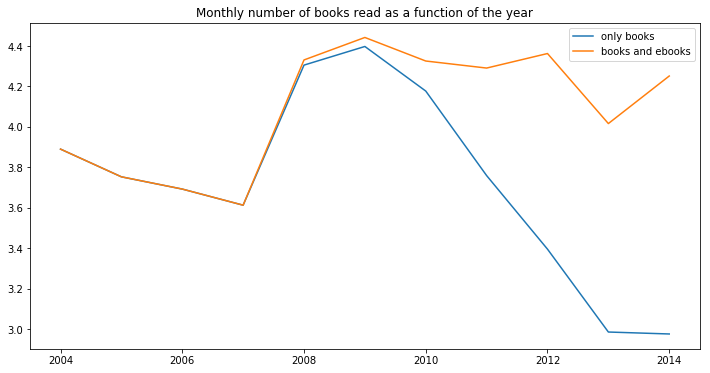

In [95]:
#Plotting of the two curves
years = physical_books_read.toPandas()['Year'].values

books = physical_books_read.toPandas()['monthly_books'].values
total_books = books_read.toPandas()['monthly_books'].values

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
plt.title("Monthly number of books read as a function of the year")
ax.plot(years,books, label='only books')
ax.plot(years,total_books, label='books and ebooks')
plt.legend()
plt.show()

We observe that among frequent users, __the appearance of the Kindle hasn't increased the number of read books per month on average but replace a fraction of these__, approximately 1 out of 4 books is an ebook by 2014. We can see that the proportion of ebooks increased in an important manner but has a tendency to settle for the last period. (This has to be nuanced by the smaller dataset gathered for the last 2014 year). These numbers are not normalized by the respective titles catalog size of each platform. though.

### 1.3 E-books to All-books ratio normalized by respective catalogue sizes

Let us include the titles catalog size factor in the analysis of the previous tendency.

We load a previously computed database constituted of previous results relative to user consumption of e-books and books per month for frequent readers and including the catalog size that has to be joined to them with the help of SQL queries.

In [451]:
kindle_proportion_time_factors = spark.read.parquet("results/df_kindle_proportion_time_factors.parquet")
kindle_proportion_time_factors.registerTempTable("kindle_proportion_time_factors")
kindle_proportion_time_factors.show(10)

+--------------------+----+-----+---------+--------+-----------------+-----------------+---------------------+--------------------+
|                User|Year|Month|nb_ebooks|nb_books|avg_kindle_rating|  avg_book_rating|kindle_catalogue_size|books_catalogue_size|
+--------------------+----+-----+---------+--------+-----------------+-----------------+---------------------+--------------------+
|A0625983252ECA1NT...|2013|   11|        0|       1|              0.0|              5.0|               324302|             1903718|
|A072353333NAMFEC9...|2013|    7|        0|       2|              0.0|              4.0|               324302|             1903718|
|A07563631RVFIZLOCOYX|2013|    1|        1|       1|              5.0|              5.0|               324302|             1903718|
|A07759332OIY0BZ48...|2013|    8|        0|       1|              0.0|              5.0|               324302|             1903718|
|      A100BTJ98E8J68|2014|    3|        1|       2|              5.0|      

In [455]:
normalized_proportion = spark.sql("""SELECT Year, AVG(ratio) AS ratio, STDDEV(ratio) AS std
                FROM (SELECT User, Year, AVG((nb_ebooks/kindle_catalogue_size)/(nb_ebooks/kindle_catalogue_size+nb_books/books_catalogue_size)) AS ratio
                 FROM kindle_proportion_time_factors
                 GROUP BY User, Year)
             GROUP BY Year
             ORDER BY Year""")
df_normalized_proportion = normalized_proportion.toPandas()

+----+--------------------+-------------------+
|Year|               ratio|                std|
+----+--------------------+-------------------+
|2008|0.026952544410628658| 0.1252574263034488|
|2009| 0.05535833968654787|0.17710264142519203|
|2010| 0.15182029796122012| 0.2771360628238975|
|2011| 0.38443060676477814| 0.3457885001934083|
|2012|  0.5070162664030109| 0.2991928594205472|
|2013| 0.47604236503290687|0.24983270422877646|
|2014|  0.5048594924349231|0.24439432980144282|
+----+--------------------+-------------------+



Let us plot this results as a error bar plot.

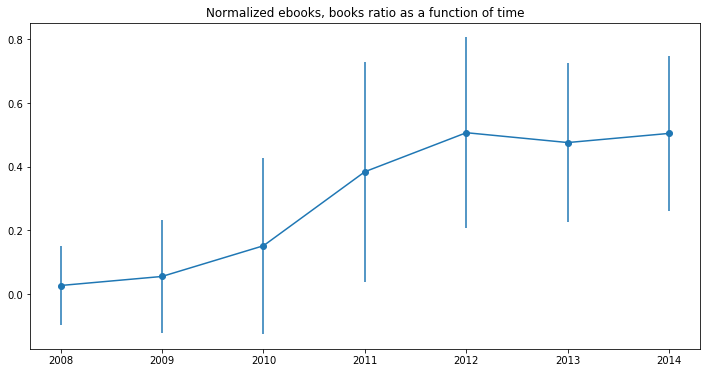

In [457]:
yerr = df_normalized_proportion['std'].values
y = df_normalized_proportion['ratio'].values
years =  df_normalized_proportion['Year'].values
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
plt.title("Normalized ebooks, books ratio as a function of time")
ax.errorbar(x = years, y= y,yerr = yerr, fmt='-o')
plt.show()

We observe a __similar growth then stabilization tendency__ for the normalized ratios. However we observe that the standard deviation is very important for each year. From this aspect, we decide to do a more in-depth analysis which focuses on the variation of each Kindle ratio population proportion with respect to the total number of frequent readers. 

### 1.4 Proportion of readers given their e-books ratio

We compute and plot the proportion of users for each 10%-width bin e-books to total books ratio as a relative stacked vertical barplot for each year from 2008 to 2014. The numbers used where tediously computed using very boring and extravagant SQL queries which we preserve the reader from.

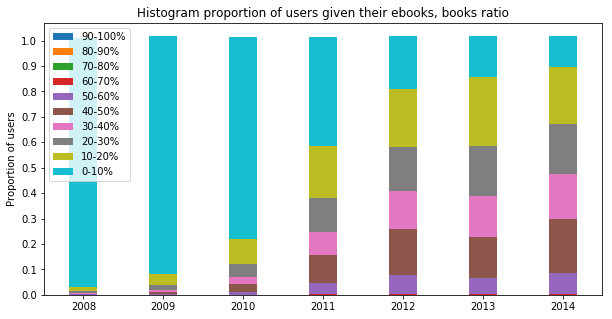

In [508]:
#Precomputed values with the help of SQL queries 
p_90_100 = np.array([0,0,0,0,0.0000294628,0.00001680711,0.00003006657])
p_80_90  = np.array([0,0,0.00030873726,0.00011118783,0.00017677682809337354,0.00019664329888798213,0.0001403107040229885])
p_70_80  = np.array([0,0,0,0.0002601795238714713,0.0008398158428652431,0.0009062691166141786,0.000781731065270936])
p_60_70  = np.array([0,0.0009398496240601503,0.0006174745291756716,0.0011826341994157785,0.0019113050216933122,0.0030009477352035538,0.0023552153889573072])
p_50_60  = np.array([0.0018181818181818182,0.003289473684210526,0.01173201605433776,0.04612273377721537,0.07465673251402058,0.062301726912901124,0.08396593416461413])
p_40_50  = np.array([0.0024242424242424242,0.005639097744360902,0.029021302871256562,0.10714665846706954,0.18168981372884607,0.16197423032316619,0.21184911868842365])
p_30_40  = np.array([0.004242424242424243,0.007518796992481203,0.02994751466502007,0.09129936019489811,0.14763383334231067,0.15830640531347293,0.17770350664511497])
p_20_30  = np.array([0.006666666666666667,0.019736842105263157,0.04970669959864156,0.1362394597726977,0.17511608282090088,0.19948180215888694,0.19493165666050905])
p_10_20  = np.array([0.01696969696969697,0.044642857142857144,0.09694350108058043,0.20199392126021498,0.22657652257164354,0.27173538993724944,0.22295370869252873])
p_0_10   = np.array([0.9757575757575757,0.9356203007518797,0.7968508799012042,0.43118842910699284,0.20841912486555708,0.16000779733428636,0.12228077855603449])

years = (2008,2009,2010,2011,2012,2013,2014)
ind = (np.arange(7))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))

p1 = plt.bar(ind, p_90_100, width)

p2 = plt.bar(ind, p_80_90, width,
            bottom=p_90_100)

p3 = plt.bar(ind, p_70_80, width,
            bottom=p_90_100+p_80_90)

p4 = plt.bar(ind, p_60_70, width,
            bottom=p_90_100+p_80_90+p_70_80)

p5 = plt.bar(ind, p_50_60, width,
              bottom=p_90_100+p_80_90+p_70_80+p_60_70)

p6 = plt.bar(ind, p_40_50, width,
            bottom=p_90_100+p_80_90+p_70_80+p_60_70+p_50_60)

p7 = plt.bar(ind, p_30_40, width,
            bottom=p_90_100+p_80_90+p_70_80+p_60_70+p_50_60+p_40_50)

p8 = plt.bar(ind, p_20_30, width,
            bottom=p_90_100+p_80_90+p_70_80+p_60_70+p_50_60+p_40_50+p_30_40)

p9 = plt.bar(ind, p_10_20, width,
            bottom=p_90_100+p_80_90+p_70_80+p_60_70+p_50_60+p_40_50+p_30_40+p_20_30)

p10 = plt.bar(ind, p_0_10, width,
            bottom=p_90_100+p_80_90+p_70_80+p_60_70+p_50_60+p_40_50+p_30_40+p_20_30+p_10_20)
plt.ylabel('Proportion of users')
plt.title('Histogram proportion of users given their ebooks, books ratio')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]), ('90-100%','80-90%','70-80%','60-70%','50-60%','40-50%','30-40%','20-30%','10-20%','0-10%'))
plt.show()

We observe that the intermetdiate e-books ratios such as 10-20%, 30-40%, 40-50% __have a tendency to increase over the years and represent an important proportion of the total readers__. However the higher percentage such a 60% and more constitute a small fraction of the users.

### 1.5 Change of e-books ratio over the years

In the previous subpart, we observed a change of proportion among the proportion of users for a given e-books ratio with the years. We desire to analyze those variations more precisely.

In [613]:
#Pre-computed data used for the latter plotting
user_ratio_variations = spark.read.parquet(RESULT_FOLDER+"user_ratio_variations.parquet").toPandas()

We define three categories of users:

- __Small Kindle readers:__ ratios $[0\%,25\%]$ of e-books to the total numbers of books read
- __Medium Kindle readers:__ ratios $[25\%,75\%]$ of e-books to the total numbers of books read
- __Large Kindle readers:__ ratios $[75\%,100\%]$ of e-books to the total numbers of books read

We then plot the number of users that remain or change their reading classes for each year as a sankey diagram.

In [614]:
#Sankey diagram plotting
SankeyWidget(links=user_ratio_variations.to_dict('records'),layout = Layout(width="1200", height="800"), margins=dict(top=0, bottom=0, left=150, right=150))

SankeyWidget(layout=Layout(height='800', width='1200'), links=[{'source': 'small:25%', 'target': '_', 'value':…

#### Pre-computed Sankey Diagram of User Ebooks Percentage Variation as a function of time ( compatiblity of the widget and display concerns )


![Title](img/sankey.png)

We can observe that __users tend to increase their relative consumption of e-books with the years__. However, it is mainly from the small to intermediate category. In addition, we observe that the number of __users reducing their Kindle consumption is relatively more important for the two last years__ transition. It could induce a resignation of the platform or a lesser interest for the support.

### 1.6 User sentiment towards the Kindle

As we observed in part 1.5, users seem to be less appealed to Kindle in proportion to classical books in the last years of the analysis. In order to have another point of view reagarding this matter, we analyze the other important component of the ratings i.e. the numerical grade in the range [1,5]. We decide to aggregate it per year, as the average difference in grades per user for the e-books minus the books rating grade. We compute this difference as a relative differenced normed by the maximal grade difference (i.e. $5-1=4$).

$$yearly\ difference\ percentage = \frac{\textrm{AVG}_{year}(\textrm{AVG}_{month,user}(ebooks\ ratings) - \textrm{AVG}_{month,user}(books\ ratings))}{4}$$

In [511]:
rating_diff = spark.sql("""SELECT Year,  AVG(diff)/4.0 AS ebooks_rating_and_books_rating_difference_percentage
            FROM
            (SELECT User,
                    Year,
                    AVG(avg_kindle_rating) -
                    AVG(avg_book_rating) AS diff
             FROM kindle_proportion_time_factors
             WHERE avg_kindle_rating > 0 AND avg_book_rating > 0
             GROUP BY User, Year)
             GROUP BY Year
             ORDER BY Year""")
rating_diff.show()

+----+----------------------------------------------------+
|Year|ebooks_rating_and_books_rating_difference_percentage|
+----+----------------------------------------------------+
|2008|                                -0.02450636032484...|
|2009|                                -0.01518851117459626|
|2010|                                -0.02020867969376...|
|2011|                                -0.02172955927016...|
|2012|                                -0.02194209314288...|
|2013|                                -0.02455211950487068|
|2014|                                -0.01798652640966...|
+----+----------------------------------------------------+



We observe that the __relative rating difference is not very marked__ (between 1.5% to 2.5%). Nonetheless, this bias is consistent given the years. This leads us to the second part of the project which consists of the user sentiment analysis in the reviews of the Kindle.

## Part 2 - Review texts analysis

In order to make a more insightful analysis of the user opinion of the Kindle platform, we decide to use natural language processing techniques on the set of reviews. However, we desire to focus on the effect of the platform itself and not on the possible influence that the read book has on the review. We proceed in the following manner.

1) We first use a Latent Dirichlet allocation (LDA) to determine if a "technical" Kindle topic is present in the reviews of the e-books. More precisely, we are looking for words such as "format", "screen", "interactivity", etc.

2) We use a TF-IDF word weighting metric to validate that the words constituing the corpus of the technical topics are indeed more present in the e-books reviews corpus. 

3) Eventually, we use TextBlob to analyze the sentiment of reviews which contain the words of the technical topic and compare the results to those of the reviews missing these terms.

### 2.1 Latent Dirichlet allocation

### 2.1.1 Loading stemmed corpus

First, we load the corpus of previously stemmed reviews. Stemming will prevent us from getting noise in our analysis from words having the same stem but being considered as different words (eg. wait, waited, waiting, ...).

Unfortunately, for various performance reasons and to be able to perform all computations in a reasonable amount of time, we first limit ourselves to a corpus of 50k reviews.

In [2]:
def get_rdd(filename, max_size = None):
    df = spark.read.parquet(DATA_FOLDER + filename)
    rdd = df.rdd.zipWithIndex().map(lambda r: (r[1], r[0]["Words"]))
    return rdd if max_size == None else sc.parallelize(rdd.take(max_size))

In [3]:
RDD_FILENAME = "stemstem.parquet"
rdd = get_rdd(RDD_FILENAME, max_size = 50000)

### 2.1.2 Preparing the data

In order to use the `LDAModels` provided by `pyspark`, we need to shape the data. More precisely, we need to compute the number of occurrences of each term in each review. This is the purpose of the function `count_words` below:

In [4]:
def count_words(rdd):
    def word_occurrences(l):
        counter = dict(Counter(l))
        return list(zip(counter.keys(), counter.values()))
    
    return rdd.mapValues(word_occurrences)

Next, we establish the set of all words present in our reviews. This is done in the `wordify` function below. `words` is constructed from iteratively taking the union of the set of words of each review. Finally, we assign to each word an unique integer index. This is going to be useful later...

In [5]:
def wordify(rdd):
    words = list(rdd.map(lambda p: set(p[1])).reduce(lambda x, y: x | y))
    return dict([(words[i], i) for i in range(len(words))])

The last step of data preparation is to map the review of each entry of `rdd` to a vector of size `len(words)` containing at index $i$ the number of occurrences of word $i$. Since each review contains only a small subset of all possible words, we naturally choose a `SparseVector` instance for obvious performance reasons.

In [6]:
def LDAify(rdd, words):
    return rdd.mapValues(lambda l: [(words[w], occurrences) for (w, occurrences) in l]).mapValues(lambda l: Vectors.sparse(len(words), dict(l))).map(lambda p: list(p))

Words can be computed in the following manner: `words = wordify(rdd)`. Nevertheless, since this computation is quite time consuming, we decided to do it once for all and to store the result in Pickle file. Hence, we load the dictionary as follows:

In [7]:
words = {}
with open(RESULTS_FOLDER + "words_lda.pickle", 'rb') as handle:
    words = pkl.load(handle)

Moreover, we create the data matrix X:

In [8]:
X = LDAify(count_words(rdd), words)

### 2.1.3 Core LDA analysis

LDA's `describeTopics()` method returns a list of `k` topics assigning to each one a word distribution. However, here words indices are used and not words themselves. Therefore, we implement the following `format_terms` function to help us retrieving a word from its index in `words`.

In [9]:
def format_terms(indices, weights):
    words_list = list(words)
    return [(words_list[index], weights[i]) for (i, index) in enumerate(indices)]

In addition, it's worth noticing that LDA depends on two hyperparameters $\alpha$ and $\beta$, describing respectively the document and term distributions. We need to tune those parameters according to our needs and we do this using a simple grid search.

This is what the `test_coefs` function below does. Also, it prints the topics created by the LDA so that we can manually evaluate their relevance to find the best values for $\alpha$ and $\beta$.

In [10]:
def test_coefs():
    res = []
    for alpha in [1.01, 1.5, 2, 3]:
        for beta in [1.01, 1.5, 2, 3]:
            print("alpha = " + str(alpha) + " / beta = " + str(beta))
            lda = LDA(k = 10).setFeaturesCol("feature").setMaxIter(100).setOptimizer("em").setDocConcentration([float(alpha)]).setTopicConcentration(float(beta))
            X_ = X.toDF(["id", "feature"])
            model = lda.fit(X_)
            res += [model.describeTopics().rdd.map(lambda r: (r[0], format_terms(r[1], r[2]))).take(10)]
    
    interesting_indices = []
    for i in range(4):
        for j in range(4):
            for k, (_, words) in enumerate(res[4*i + j]):
                if "kindl" in list(map(lambda p: p[0], words)):
                    interesting_indices.append((4*i+j, k))

In [11]:
# Chosen from above
alpha = 2
beta = 1.5

Again, training a LDA model is quite time consuming. Therefore, we saved the model for the values $\alpha = 1$ and $\beta = 1.5$ in a Parquet file. Retrieving the model can be done as such:

In [12]:
best_model = DistributedLDAModel.load(RESULTS_FOLDER + "kindle_lda_model.parquet")

### 2.1.3 Topics extraction

In [13]:
def print_topics(model, dictionary):
    words_list = list(dictionary)
    for i, words in model.describeTopics(10).rdd.map(lambda r: (r[0], (zip(r[1], r[2])))).groupByKey().sortByKey().collect():
        print("Topic " + str(i+1))
        for word_indices in words:
            for word, per in (map(lambda w: (words_list[w[0]], w[1]), word_indices)):
                print("    " + word + ": " + str(100*per) + "%")
        print()

print_topics(best_model, words)

Topic 1
    review: 1.669342772819849%
    relationship: 1.227819401281716%
    togeth: 1.1226048807265143%
    into: 0.9942960889184277%
    onli: 0.9100196149317308%
    sexi: 0.8871170059162949%
    she': 0.8252354260346444%
    doesn't: 0.7530020812918945%
    romanc: 0.7046308878346287%
    passion: 0.5523344025810424%

Topic 2
    novel: 3.416132220056701%
    mysteri: 3.056578227312123%
    twist: 2.247111886674283%
    suspens: 1.6679165260551003%
    excel: 1.6058436532190203%
    fiction: 1.342177967207062%
    adventur: 1.2226281607025942%
    murder: 1.1559497799029421%
    humor: 1.138142625814316%
    action: 0.9842488594565195%

Topic 3
    seri: 7.396401356429165%
    becaus: 5.167379252584321%
    author: 4.1938369866492335%
    didn't: 3.359057931263465%
    definit: 2.6682958127516434%
    anoth: 1.8695779456988404%
    onli: 1.6990315579187822%
    couldn't: 1.6985199654105725%
    wasn't: 1.6225247585990297%
    disappoint: 1.4891925098047047%

Topic 4
    stori: 2

From the topics displayed above, we note that a large number of them seem related to specific genres that we might find in books. For example, the topic containing "relationship", "together", "sexi", "romanc", "passion" may be a genre that we could call "Love & Romance".

However, __a specific topic has retained our whole attention. It is topic number 6, essentially containing words that are really specific to Kindle features__.

### 2.2 TF-IDF

We know from the LDA analysis above that users talk about the Kindle and its technology in their reviews. Now we wish to target those reviews. For this, we need to extract their specific words.

In order to achieve this, we will use the TF-IDF method, allowing us to extract words specific to the Kindle reviews and we will keep only the ones which are related to technology or the Kindle in general.

The code and experiments to extract the words are located in `tfidf.py`. The recovery of the words was a laborious task, we extracted the 100 most specific words which appears once every $10^6$ reviews, then once every $10^5$ reviews and so on until the words that appear once every $10^3$ reviews. Hence we are not going to display the full detail of this analysis, but rather the results we found.

In [ ]:
# Hardcoded results in a dictionary
words = ["charger", "paperwhit", "headphone", "warranti", "e-ink", "well-format",\
         "recharge", "tablet", "kindl", "ebook", "e-read",\
          "download", "screen", "device", "easi", "complaint", "price", \
          "disappoint", "worth", "recommend", "hate"]
values = [1.965, 1.940, 1.883, 1.877, 1.777, 1.775, 1.600, 1.587, 1.574, 1.551, 1.535, \
          1.460, 1.437, 1.324, 1.312, 1.307, 1.289, 1.280, 1.260, 1.241, 1.187]
df_total = pd.DataFrame({"Words" : words, "TF-IDF values" : values})
len(words)

We found a nice gradient of colors on http://colorbrewer2.org/#type=sequential&scheme=PuBuGn&n=4 that allows us to display our results in a nice fashion.

Then we will display the results on two rows for the sake of readibility.

In [584]:
def highlighting(s):
    e = s[0]
    if e < 1.2:
        return ['background-color: #d7191c']
    elif e < 1.4:
        return ['background-color: #fdae61']
    elif e < 1.6:
        return ['background-color: #ffffbf']
    elif e < 1.8:
        return ['background-color: #a6d96a']
    else:
        return ['background-color: #1a9641']

In [585]:
dict_ = {}
for i in range(11):
    dict_[words[i]] = [values[i]]
df_dict = pd.DataFrame(dict_)
df_dict.style.apply(highlighting)

,charger,paperwhit,headphone,warranti,e-ink,well-format,recharge,tablet,kindl,ebook,e-read
0,1.965,1.94,1.883,1.877,1.777,1.775,1.6,1.587,1.574,1.551,1.535


In [586]:
dict2_ = {}
for i in range(11, len(words)):
    dict2_[words[i]] = [values[i]]
df_dict2 = pd.DataFrame(dict2_)
df_dict2.style.apply(highlighting)

,download,screen,device,easi,complaint,price,disappoint,worth,recommend,hate
0,1.46,1.437,1.324,1.312,1.307,1.289,1.28,1.26,1.241,1.187


Thanks to this analysis, we are able to target Kindle-specific words which are about technology. In the results displayed, a color and a number is associated to each word. A color close to green and a number close to 2 denotes a very specific word, i.e a number that appears twice more often in the Kindle corpus than in the Books one. At the other side of the gradient, a color close to red and a value close to one denotes a not very specific word. A word with a value of 1 appears exactly the same number of times in the two corpuses.

Those words will help us target the technology-specific reviews about the Kindle in the next step of our analysis.

### 2.3 Sentiment analysis using TextBlob

From the two previous steps, we were able to determine that there was a meaningful technical topic in the Kindle reviews. We now proceed to a sentiment analysis with the help of the TextBlob library which yields results in the range [-1,1] given a piece of text, where -1 being extremly negative sentiment, 1 very positive and 0 neutral. We perform the analysis on the set of reviews for the frequent readers from part 1 to keep a consistency throughout the project. We split the dataset into technical and non-technical reviews depending on whether the review text contains words from the previously defined technical topic dictionary.

In [553]:
#Loading of the reduced kindle reviews corresponding to the reviews left by the frequent books and ebooks readers population
df_reduced_reviews_kindle = spark.read.parquet(RESULT_FOLDER+'kindle_reduced_review_year.parquet')
df_reduced_reviews_kindle.registerTempTable("df_reduced_reviews_kindle")

In [193]:
#Defintion of the technical dictionnary
dictionary = ['kindl',
              'inform',
              'easi',
              'worth',
              'purchas',
              'chapter',
              'price',
              'edit',
              'writer',
              'error',
              'ebook',
              'easi',
              'version',
              'e-ink',
              'well-format',
              'e-read',
              'screen',
              'device',
              'complaint',
              'display',
              'layout',
              'format',
              'annot',
              'interactiv']


We decide to use SnowballStemmer this time because it has the advantage to take as parameter a language which improves on the quality of the stemming.

In [ ]:
stemmer = SnowballStemmer("english")

In [557]:
#We stem, then filter reviews to keep only those that contains a word present in the dictionnary. Eventually we join the
#stemmed words constituing the reviews into a sentence from which we quantify the sentiment with TextBlob
df_kindle_filtered = df_reduced_reviews_kindle.rdd.map(lambda row: (row.year, row.reviewText.split(" "))).map(lambda row: (row[0],[stemmer.stem(word) for word in row[1]])).filter(lambda row: any(word in row[1] for word in dictionary)).map(lambda row: (row[0], " ".join(row[1]))).toDF()
df_kindle_filtered.write.parquet(RESULT_FOLDER+"kindle_reviews_textblob.parquet")
df_kindle_filtered = spark.read.parquet(RESULT_FOLDER+"kindle_reviews_textblob.parquet")
df_kindle_filtered.registerTempTable("df_kindle_filtered")

In [560]:
#We do the same process as explained above but on the reviews that do not contain a technical aspect in their words
df_reviews_stemmed = df_reviews_kindle.rdd.map(lambda row: (row.year, row.reviewText.split(" "))).map(lambda row: (row[0],[stemmer.stem(word) for word in row[1]])).map(lambda row: (row[0], " ".join(row[1]))).toDF()
df_reviews_stemmed.registerTempTable("df_reviews_stemmed")
df_difference_reviews = spark.sql("""(SELECT * 
                                      FROM df_reviews_stemmed)
                                      MINUS
                                      (SELECT _2 AS reviewText, _1 AS year
                                      FROM df_kindle_filtered)""")

df_difference_reviews.write.parquet(RESULT_FOLDER+"kindle_difference_reviews_filtered.parquet")
df_difference_reviews = spark.read.parquet(RESULT_FOLDER+"kindle_difference_reviews_filtered.parquet")
df_blob = df_kindle_filtered.rdd.map(lambda row: (row._1,TextBlob(row._2).sentiment.polarity)).toDF()
df_blob_difference = df_difference_reviews.rdd.map(lambda row: (row._1,TextBlob(row._2).sentiment.polarity)).toDF()

In [561]:
#Registration of tables for SQL queries
df_blob.registerTempTable("df_blob")
df_blob_difference.registerTempTable("df_blob_difference")

In [581]:
#Techincal reviews TextBlob stats
df_blob_stat = spark.sql("""SELECT _1 AS Year, AVG(_2) as average, STD(_2) AS std, COUNT(_2) AS number_reviews
             FROM df_blob
             GROUP BY Year
             ORDER BY Year
             """)
df_blob_stat.show()

+----+-------------------+-------------------+--------------+
|Year|            average|                std|number_reviews|
+----+-------------------+-------------------+--------------+
|2008|0.19170204075339695|0.13930735327609967|           162|
|2009|0.19735687523836762|0.17213023912167863|           349|
|2010| 0.1832341597207311|  0.135431797834834|          1464|
|2011|0.18609293900605972|0.13969769121661657|          8424|
|2012|0.20783973016559112|0.17055396160778094|         36739|
|2013|0.22910094529968664|0.19675157240674276|        101647|
|2014|0.23284503606947587|0.19219510432923484|         92805|
+----+-------------------+-------------------+--------------+



In [582]:
#Non-Techincal reviews TextBlob stats
df_blob_difference_stat = spark.sql("""SELECT _1 AS Year, AVG(_2) as average, STD(_2) AS std, COUNT(_2) AS number_reviews
             FROM df_blob_difference
             GROUP BY Year
             ORDER BY Year""")
df_blob_difference_stat.show()

+----+-------------------+-------------------+--------------+
|Year|            average|                std|number_reviews|
+----+-------------------+-------------------+--------------+
|2008|0.21131292414251338|0.15271562128145633|           575|
|2009|0.20178328012244898|0.15777446571937237|          1001|
|2010| 0.2011067234320961|0.15131877988800102|          4460|
|2011|0.19909737987842907| 0.1652592104606844|         24951|
|2012|0.22477877980356284| 0.1942601404685062|        121556|
|2013| 0.2496009341882106|0.22050814490666107|        449528|
|2014| 0.2532085213393239|0.21803204738055204|        428195|
+----+-------------------+-------------------+--------------+



In [588]:
#df_blob_stats_pandas = df_blob_stat.toPandas()
df_blob_difference_stat_pandas = df_blob_difference_stat.toPandas()

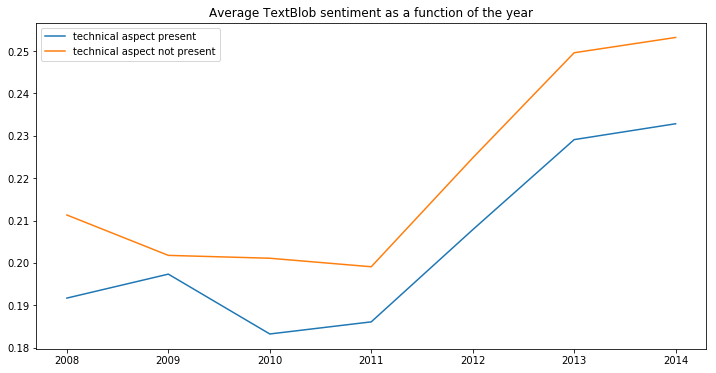

In [589]:
#Plotting of the two curves
years = df_blob_stats_pandas['Year'].values

technical = df_blob_stats_pandas['average'].values
non_technical = df_blob_difference_stat_pandas['average'].values

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
plt.title("Average TextBlob sentiment as a function of the year")
ax.plot(years,technical, label='technical aspect present')
ax.plot(years,non_technical, label='technical aspect not present')
plt.legend()
plt.show()

We observe that the __reviews containing the technical aspects have consistently a lower average TextBlob score than the non-technical reviews__ which leads us to think that the Kindle support indeed has a negative impact on the user appreciation of the support. However we need to statistically confirm this hypothesis.

#### 2.4 Statistical validation Tests

In this final subpart we perform two statistical tests to check the validity of our previous hypothesis.

1) p-values for each year

2) t-test for the whole

In order to do so, we first plot the relative distribution of the TextBlob scores to ensure that those follow normal distribution, for the tests to be applicable.

In [563]:
#Conversion to Pandas dataframe of the dataframes
df_blob_pandas = df_blob.toPandas()
df_blob_difference_pandas = df_blob_difference.toPandas()

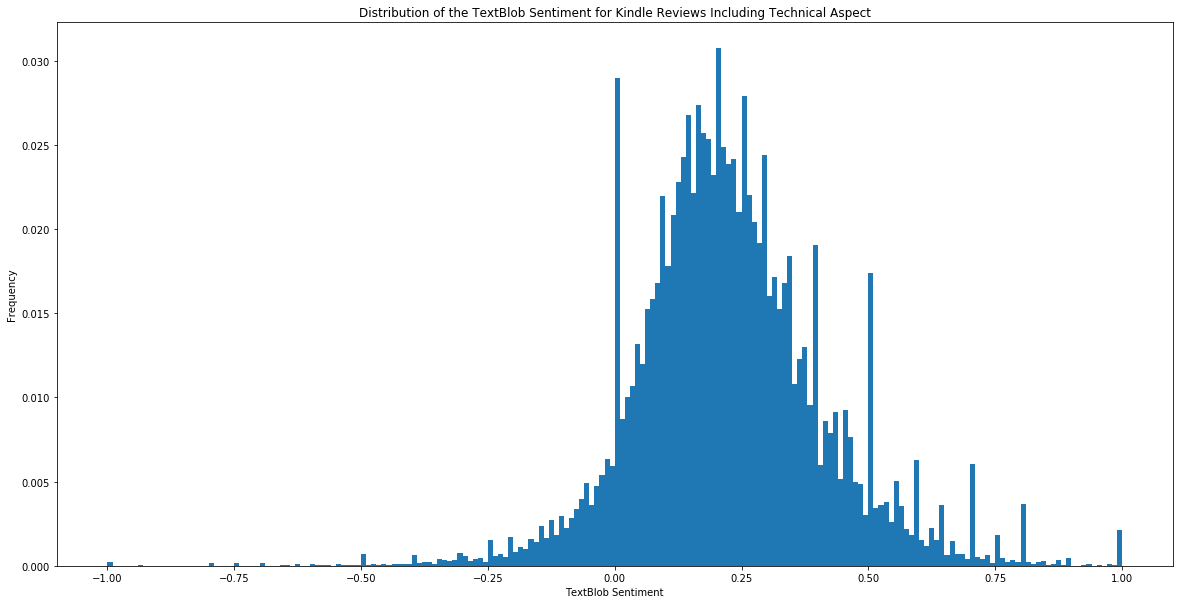

In [575]:
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df_blob_pandas['_2'].values, bins=200,  weights=np.zeros_like(df_blob_pandas['_2'].values) + 1. / df_blob_pandas['_2'].values.size, cumulative=0)
ax.set_title("Distribution of the TextBlob Sentiment for Kindle Reviews Including Technical Aspect")
ax.set_xlabel('TextBlob Sentiment', size=10)
ax.set_ylabel('Frequency', size=10)
fig.set_size_inches((20,10))
ax.legend

plt.show()

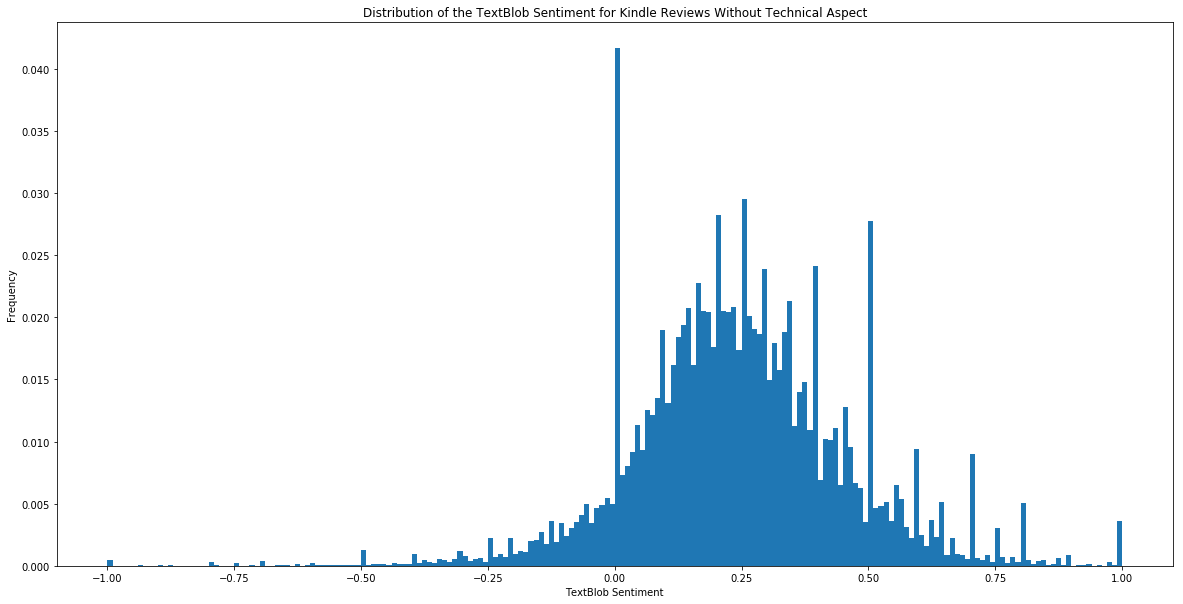

In [576]:
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df_blob_difference_pandas['_2'].values, bins=200,  weights=np.zeros_like(df_blob_difference_pandas['_2'].values) + 1. / df_blob_difference_pandas['_2'].values.size, cumulative=0)
ax.set_title("Distribution of the TextBlob Sentiment for Kindle Reviews Without Technical Aspect")
ax.set_xlabel('TextBlob Sentiment', size=10)
ax.set_ylabel('Frequency', size=10)
fig.set_size_inches((20,10))
ax.legend

plt.show()

Excepting some outliers for the value around 0 which concludes to a neutral review and are mostly due to the limitation of the algorithm used by TextBlob, __we confirm that the distributions are Gaussian normal__. We can therefore apply the two tests mentionned above.

#### 2.4.1 p-value computation

Here we remove the dust from the probability and statistics notebooks to compute a precise p-value to evaluate the probability that the sentiment analysis for the technical reviews have the same distribution that the sentiment analysis for the non-technical ones.

Let's call $T \sim \mathcal{N}(\mu_T, \sigma_T)$ the distribution of the sentiment for one technical review and $O \sim \mathcal{N}(\mu_O, \sigma_O)$ the distribution of the sentiment for one non-technical review.

Then we define $A = \frac{1}{N} \sum_{i=1}^N T_i \sim \mathcal{N}(\mu_A, \sigma_A)$.

Hence our hypothesis $H_0$ and $H_1$ will be :

$H_0$ : $A$ has the same distribution as $O$.

$H_1$ : $A$ and $O$ do not have the same distribution.

##### Under assumption $H_0$

$$\mu_A = \frac{1}{N} \sum_{i=1}^N \mathbb{E}[T_i] = \mu_T = \mu_O$$

$$\sigma_A^2 = \frac{1}{N^2}\sum_{i=1}^N Var[T_i] = \frac{\sigma_T^2}{N} = \frac{\sigma_O^2}{N}$$

we then compute the probability that under those assumptions, we obtain a value of $A$ less or equal to the value of $\mu_T$ we observed.

\begin{align}
\mathbb{P}(A \leq \mu_T | H_0) &= 1 - \mathbb{P}(A > \mu_T | H_0)\\
&= 1 - \mathbb{P}\left(\frac{A - \mu_0}{\sqrt{\frac{\sigma_0^2}{N}}}  > \frac{\sqrt{N}(\mu_T - \mu_0)}{\sigma_0}\right)\\
&= 1 - \mathbb{P}\left(Z > \frac{\sqrt{N}(\mu_T - \mu_0)}{\sigma_0}\right)\\
&= 1 - \mathcal{Q}\left(\frac{\sqrt{N}(\mu_T - \mu_0)}{\sigma_0}\right)
\end{align}

Where $Z \sim \mathcal{N}(0, 1)$, and $\mathcal{Q}(x) = \mathbb{P}(Z > x)$ is the tail distribution function of the standard normal distribution.

Hence we have our p-value :

$$p-value = 1 - \mathcal{Q}\left(\frac{\sqrt{N}(\mu_T - \mu_0)}{\sigma_0}\right)$$

We compute it for the years 2008 - 2014 :

In [4]:
import pandas as pd

def highlighting(s):
    if s == u'\u2713':
        return 'background-color: #a6d96a'
    elif s == u'\u2717':
        return 'background-color: #fdae61'
    return ''

dict_ = {
    "2008" : [0.0512, u'\u2713', u'\u2717', u'\u2717'],
    "2009" : [0.3012, u'\u2717', u'\u2717', u'\u2717'],
    "2010" : [3e-6, u'\u2713', u'\u2713', u'\u2713'],
    "2011" : [2.63e-13, u'\u2713', u'\u2713', u'\u2713'],
    "2012" : [2.01e-63, u'\u2713', u'\u2713', u'\u2713'],
    "2013" : [2.22e-193, u'\u2713', u'\u2713', u'\u2713'],
    "2014" : [4.73e-179, u'\u2713', u'\u2713', u'\u2713']}

rows_names = {0:"p-value", 1:"0.1 confidence", 2:"0.01 confidence", 3:"0.001 confidence"}

print("p-values for hypothesis H0 over the years :")
df = pd.DataFrame(dict_)
df = df.rename(index=rows_names)
df.style.applymap(highlighting)

p-values for hypothesis H0 over the years :


,2008,2009,2010,2011,2012,2013,2014
p-value,0.0512,0.3012,3e-06,2.63e-13,2.01e-63,2.22e-193,4.73e-179
0.1 confidence,✓,✗,✓,✓,✓,✓,✓
0.01 confidence,✗,✗,✓,✓,✓,✓,✓
0.001 confidence,✗,✗,✓,✓,✓,✓,✓


__The p-value for the hypothesis $H_0$ is way less than 0.001 for all the years > 2009__. We even reach p-values that can be considered as null after 2012.

We can still notice a special result in 2009 where the p-value is 0,3012. However, computing the the p-value the other way around (considering that the distribution of the sentiment of the technical aspects is the one we computed) also give us a high p-value of 0,3165.

#### 2.4.2 t-test

Since the sizes of the two datasets are several orders of magnitude apart given the year, we decide to perform an additional t-test statistic in a time-invariant setting (all years confoud) and from which we sample the same amount of datapoints to make sure that the previous test is suitable. We choose 10k points since this value allows us to approximate the $t_{df,\alpha}$ by the normal law distribution values. In addition, before sampling we remove the outliers i.e. values with TextBlob score equal to 0.

We use the following formula to compute the t-value:

$$t = \frac{M_{non\ tech}-M_{tech}}{\sqrt{ \frac{Var_{non\ tech}}{n_{non\ tech}} + \frac{Var_{tech}}{n_{tech}} }}$$

Where:

- $M_{tech}$: the empirical mean for reviews including technical aspect
- $M_{non\ tech}$: the empirical mean for reviews not including technical aspect
- $Var_{tech}$: the empircal variance for reviews including technical aspect
- $Var_{non\ tech}$: the empircal variance for reviews not including technical aspect
- $n_{tech}$: the number of samples for reviews including technical aspect
- $n_{non\ tech}$: the number of samples for reviews not including technical aspect

In our case the to last quantities are the same and equal to 10'000.

In [605]:
#Sampling after 
df_blob_pandas_sample = df_blob_pandas[df_blob_pandas._2 != 0].sample(n = 10000)
df_blob_difference_pandas_sample = df_blob_difference_pandas[df_blob_difference_pandas._2 != 0].sample(n = 10000)

In [603]:
m_tech = np.mean(df_blob_pandas_sample['_2'].values)
m_non_tech = np.mean(df_blob_difference_pandas_sample['_2'].values)
var_tech = np.var(df_blob_pandas_sample['_2'].values)
var_non_tech = np.var(df_blob_difference_pandas_sample['_2'].values)
n = 10000

In [604]:
t = (m_non_tech-m_tech)/np.sqrt((var_tech/n)+(var_non_tech/n))
t

9.000461138723196

We observe a large t-value which confidently confirms that there is a statistical difference in between the distributions.

Hence we conclude that we can safely __reject the null hypothesis__ and consequently that __the distribution of the sentiment for reviews about the technical aspect of the Kindle is not distributed the same way as the one for the reviews about the non-technical aspects__. Although this difference is tiny, it is noticeable and not due to randomness.

## Part 3 - Conclusion

The Kindle is a highly advertised product by Amazon that releases often upgrades of the device and pushes it towards its customers by placing it on the frontpage of its store. It appeals to a lot of users who give it a try and its popularity is important given its several orders smaller catalog compared to classical physical books. However, frequent readers seem not to totally switch to this new form of reading, still prefering old school books. In addition, in the last years (of the available data) users seemed to make a strong come back to the classical way of reading abandoning the platform in favor of the physical offer. This can interpreted with the recent trend among younger generations who re-discover old supports and favorize them as in the case of books.

_Ebook sales continue to fall as younger generations drive appetite for print_, the Guardian, Sian Cain,14.03.2017,  https://www.theguardian.com/books/2017/mar/14/ebook-sales-continue-to-fall-nielsen-survey-uk-book-sales